In [1]:
import numpy as np
import cv2 as cv
import pdb
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Using SIFT features
max_pts = 2000
sift = cv.SIFT_create(nfeatures=max_pts)

In [3]:
# FLANN parameters (Matcher of key points between frames)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)

In [4]:
def draw_and_save_img(frame, p, out_dir, k):
    for i in range(p.shape[0]):
        pt = p[i].reshape(-1)
        cv.circle(frame, (int(pt[0]), int(pt[1])), 3, (0, 255, 0), -1)
    f_name = 'frame_' + str(k) + '.png'
    cv.imwrite(os.path.join(out_dir, f_name), frame)

In [5]:
dir_name = './castlejpg'
frame_max = 27
out_dir = './castle_pts'

kp_points = []
mp_points = []

# read first frame and detect SIFT features
old_frame = cv.imread(os.path.join(dir_name, 'castle.000.jpg'))
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

kp0, des0 = sift.detectAndCompute(old_gray, None) # training
p0 = cv.KeyPoint_convert(kp0)
kp_points.append(kp0)
draw_and_save_img(old_frame, p0, out_dir, 0)

In [6]:
# for every frame find keypoints, match them, store match object and keypoints
skip = 1 # skip frames
for f in range(1, frame_max + 1, skip):
    some_numb = '{0}'.format(str(f).zfill(3))
    f_name = os.path.join(dir_name, 'castle.{}.jpg'.format(some_numb))
    
    frame = cv.imread(f_name)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    kpi, desi = sift.detectAndCompute(gray, None) #query 
    pi = cv.KeyPoint_convert(kpi)
    kp_points.append(kpi)

    matches = flann.knnMatch(desi, des0, k=1)
    matches = [m[0] for m in matches]
    
    mp_points.append(matches)
    
    draw_and_save_img(frame, pi, out_dir, f)
    
    des0 = desi

In [7]:
# make link list, update class id of key point to its parent
for idx, m_list in enumerate(mp_points):
    for k in kp_points[idx+1]:
        k.class_id = -2
    
    for m in m_list:
        dist = m.distance
        imgIdx = m.imgIdx
        queryIdx = m.queryIdx # 2, i
        trainIdx = m.trainIdx # 1, 0

        k_2 = kp_points[idx+1][queryIdx]
        k_2.class_id = trainIdx

In [8]:
# DFS functions
def find_chain_driver(keypoint, z):
    keypoint_list = [keypoint]
    return find_chain(keypoint_list, z)

In [9]:
def find_chain(key_point_list, z):
    key_point = key_point_list[-1]
    if z == 0:
        return [key_point]
    else:
        temp_list = find_chain([kp_points[z-1][key_point.class_id]], z-1)
        for item in temp_list:
            key_point_list.append(item)
        return key_point_list

In [10]:
# back tracking, start from last frame key point, and go till first frame
z = len(kp_points) - 1

chain_list = []
for k in kp_points[z]:
    chain = find_chain_driver(k, z)
    chain_list.append(chain)

print('graph made')

graph made


In [11]:
# convert chains of key points to pixels
frame_points = []
for l in chain_list:
    points = cv.KeyPoint_convert(l)
    frame_points.append(points)

points = np.array(frame_points)

ftr_pts = points.shape[0]
n_frames = points.shape[1]
print('n_frames (F):', n_frames, ', Points (P):', ftr_pts)

points = np.swapaxes(points, 2, 0)

U = points[0]
V = points[1]
print("U:", U.shape, "V:", V.shape, "[ F X P ]")
W = np.vstack((U, V))
W = W - np.mean(W, axis=1)[:, None]
W = W.astype('float32')
print("W:", W.shape, "[ 2F X P ]")

swap = 0
if W.shape[0] < W.shape[1]:
    W = W.T
    swap = 1

u, s, vh = np.linalg.svd(W, full_matrices=False)
top_s_sqrt = np.diag(np.sqrt(s[:3]))
if swap:
    old_u = u.copy()
    u = vh.T
    vh = old_u.T

top_u = u[:, :3]
top_vh = vh[:3, :]

R = np.dot(top_u, top_s_sqrt)
S = np.dot(top_s_sqrt, top_vh)
print("R:",R.shape, "[ 2F X 3 ]", "S:",S.shape, "[ 3 X P ]")

n_frames (F): 28 , Points (P): 2000
U: (28, 2000) V: (28, 2000) [ F X P ]
W: (56, 2000) [ 2F X P ]
R: (56, 3) [ 2F X 3 ] S: (3, 2000) [ 3 X P ]


In [12]:
def g(v1, v2):
    [a, b, c] = v1
    [x, y, z] = v2

    res = [a*x, 2*a*y, 2*a*z, b*y, 2*b*z, c*z]
    return res

In [13]:
def mat_G_maker(G, c, R1, R2, same=0):
    c.fill(same)
    n = R1.shape[0]
    for i in range(n):
        r1 = R1[i, :]
        r2 = R2[i, :]
        res = g(r1, r2)
        G[i, :] = res

    return G, c

In [14]:
R_i = R[:n_frames, :]
R_j = R[n_frames:, :]

assert R_i.shape[0] == R_j.shape[0]

G1, c1 = mat_G_maker(np.zeros((n_frames, 6)), np.zeros((n_frames, 1)), \
    R_i, R_i, same=1)
G2, c2 = mat_G_maker(np.zeros((n_frames, 6)), np.zeros((n_frames, 1)), \
    R_j, R_j, same=1)
G3, c3 = mat_G_maker(np.zeros((n_frames, 6)), np.zeros((n_frames, 1)), \
    R_i, R_j, same=0)


G = np.vstack((G1, G2, G3))
c = np.vstack((c1, c2, c3))
c = c.squeeze()

In [15]:
# # option 1: least square inbuilt
# l = np.linalg.lstsq(G, c, rcond=None)[0]

# # option 2: least square solution from scratch
GTG_inv = np.linalg.pinv(np.dot(G.T, G))
l = np.dot(np.dot(GTG_inv, G.T), c)

# # option 3: use pinv to solve linear equation
# l = np.pinv(G) * c

In [16]:
L = np.zeros((3, 3))

L[0, 0] = l[0]
L[1, 1] = l[3]
L[2, 2] = l[5]

L[0, 1] = l[1]
L[1, 0] = L[0, 1]

L[0, 2] = l[2]
L[2, 0] = L[0, 2]

L[1, 2] = l[4]
L[2, 1] = L[1, 2]

In [17]:
# enfore PSD if not
d_, V_ = np.linalg.eig(L)
D = np.diag(d_)
D[D < 0] = 0.00001

print("new L close enough?:", np.allclose(L, np.dot(V_, np.dot(D, V_.T))))
L = np.dot(V_, np.dot(D, V_.T))

Q = np.linalg.cholesky(L)

R_true = np.dot(R, Q)
S_true = np.dot(np.linalg.inv(Q), S)

X = S_true[0, :]
Y = S_true[1, :]
Z = S_true[2, :]

factor = 1
pointcloud = np.zeros((X.shape[0], 3))
pointcloud[:, 0] = X
pointcloud[:, 1] = Y
pointcloud[:, 2] = Z * factor

np.savetxt('points_castle.txt', pointcloud, fmt='%.2f', delimiter=',')

new L close enough?: True


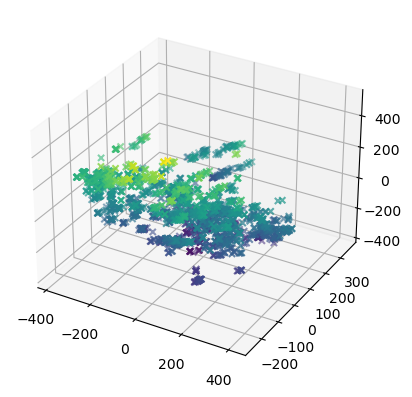

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter(pointcloud[:, 0],   # x
           pointcloud[:, 1],   # y
           pointcloud[:, 2],   # z
           c=pointcloud[:, 2], # height data for color,
           marker="x")

plt.savefig('castle_snapshot.png')